In [1]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import json
#import seaborn as sns
import numpy as np
import os
import re
import seaborn as sns
from inference import Estimator
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import importlib
import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import krippendorff

In [2]:
statements = [
'Newsworthiness',
 'Understandability',
 'Expertise',
 'Fun',
 'Importance',
 'Interestingness',
 'Sharing',
 'Benefit',
 'Surprisingness',
 'Controversy',
 'Exaggeration',
'Reading']

def get_news_values(texts, model='roberta-large-score'):
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    model = Estimator(tokenizer='roberta-large', model='../models/src/new_model/%s/0/best_model'%model,num_labels=len(statements),cuda = False)
    predictions = model.predict(texts)
    res_dict = {}
    for i,s in enumerate(statements):
        res_dict[s] = [it[i] for it in predictions]
        
    return res_dict
def num2cat(num):
    if num < 10:
        return '0' + str(int(num))
    if num <= 15:
        return str(int(num))
    elif num <= 20:
        return '>15'
    #elif num <= 30:
    #    return '21-30'
    else:
        return '>20'

In [7]:
train = pd.read_json('../data/nishal/train.json', orient='records')
train['split'] = 'train'
val = pd.read_json('../data/nishal/validate.json', orient='records')
val['split'] = 'val'
df = pd.concat([train,val])
df['text'] = [t + ' ' + it for t, it in zip(df['title'], df['summary'])]

In [8]:
df

,arxiv_id,arxiv_url,title,summary,published,authors,arxiv_primary_category,readability,actuality,controversy,relevance_magnitude,relevance_valence,newsworthiness_crowd_sum,split,nw_expert1,nw_expert2,newsworthiness_expert,text
0,2101.00183v1,http://arxiv.org/abs/2101.00183v1,Early Prediction of Heart Disease Using PCA an...,Worldwide research shows that millions of live...,2021-01-01T00:00:00.000Z,"['Md. Touhidul Islam', 'Sanjida Reza Rafa', 'M...",cs.lg,0.90,4.333333,2.333333,3.666667,3.889,3.555583,train,NaN,NaN,NaN,Early Prediction of Heart Disease Using PCA an...
1,2101.00289v1,http://arxiv.org/abs/2101.00289v1,Design and Actuator Optimization of Lightweigh...,Pediatric exoskeletons offer great promise to ...,2021-01-01T00:00:00.000Z,"['Sainan Zhang', 'Tzu-Hao Huang', 'Chunhai Jia...",cs.ro,0.79,2.000000,1.333333,2.666667,3.889,2.472250,train,NaN,NaN,NaN,Design and Actuator Optimization of Lightweigh...
2,2101.00531v1,http://arxiv.org/abs/2101.00531v1,Context-Aware Safe Reinforcement Learning for ...,Safety is a critical concern when deploying re...,2021-01-02T00:00:00.000Z,"['Baiming Chen', 'Zuxin Liu', 'Jiacheng Zhu', ...",cs.lg,0.83,4.333333,2.000000,3.666667,3.333,3.333250,train,NaN,NaN,NaN,Context-Aware Safe Reinforcement Learning for ...
3,2101.00585v1,http://arxiv.org/abs/2101.00585v1,UPSLAM: Union of Panoramas SLAM,We present an empirical investigation of a new...,2021-01-03T00:00:00.000Z,"['Anthony Cowley', 'Ian D. Miller', 'Camillo J...",cs.ro,0.89,4.000000,3.333333,5.000000,4.444,4.194333,train,NaN,NaN,NaN,UPSLAM: Union of Panoramas SLAM We present an ...
4,2101.00633v2,http://arxiv.org/abs/2101.00633v2,Outcome-Explorer: A Causality Guided Interacti...,The widespread adoption of algorithmic decisio...,2021-01-03T00:00:00.000Z,"['Md Naimul Hoque', 'Klaus Mueller']",cs.hc,0.91,4.333333,3.666667,4.333333,3.333,3.916583,train,NaN,NaN,NaN,Outcome-Explorer: A Causality Guided Interacti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2011.12548v1,http://arxiv.org/abs/2011.12548v1,Measuring Happiness Around the World Through A...,"In this work, we analyze the happiness levels ...",2020-11-25T00:00:00.000Z,"['Rustem Ozakar', 'Rafet Efe Gazanfer', 'Y. Si...",cs.ai,0.93,4.333333,1.333333,5.000000,3.889,3.638917,val,3.0,4.0,3.5,Measuring Happiness Around the World Through A...
51,2011.12684v2,http://arxiv.org/abs/2011.12684v2,Denmark's Participation in the Search Engine T...,This report describes the participation of two...,2020-11-25T00:00:00.000Z,"['Lucas Chaves Lima', 'Casper Hansen', 'Christ...",cs.ir,0.85,3.333333,1.666667,4.333333,2.778,3.027833,val,2.0,3.0,2.5,Denmark's Participation in the Search Engine T...
52,2011.13238v1,http://arxiv.org/abs/2011.13238v1,Towards Interpretable Multilingual Detection o...,his paper describes our techniques to detect h...,2020-11-26T00:00:00.000Z,['Alvi Md Ishmam'],cs.cl,0.91,4.666667,5.000000,4.666667,1.667,4.000083,val,4.0,4.0,4.0,Towards Interpretable Multilingual Detection o...
53,2011.13389v1,http://arxiv.org/abs/2011.13389v1,Generalization in Reinforcement Learning by So...,Extensive efforts have been made to improve th...,2020-11-26T00:00:00.000Z,"['Nicklas Hansen', 'Xiaolong Wang']",cs.lg,0.81,2.333333,2.333333,4.000000,2.778,2.861167,val,2.0,2.0,2.0,Generalization in Reinforcement Learning by So...


In [9]:
res_dict = get_news_values(list(df['text']), 'roberta-large-seeds-full-l2_0.2-agg-full-final-label')
for it in res_dict:
    df[it] = res_dict[it]

0it [00:00, ?it/s]/opt/anaconda/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


start tokenizing 555 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [00:02,  2.14s/it]


In [51]:
krippendorff.alpha(np.array(val[['nw_expert1','nw_expert2']]).transpose(), level_of_measurement='ordinal')

0.16260833722455215

In [20]:
df.columns

Index(['arxiv_id', 'arxiv_url', 'title', 'summary', 'published', 'authors',
       'arxiv_primary_category', 'readability', 'actuality', 'controversy',
       'relevance_magnitude', 'relevance_valence', 'newsworthiness_crowd_sum',
       'split', 'nw_expert1', 'nw_expert2', 'newsworthiness_expert', 'text',
       'My_social_media_feed', 'General_public',
       'News_story_is_interesting_to_me', 'Tackles_an_important_issue',
       'Shouldnt_be_public_outside_science', 'Would_share_on_wider_forum',
       'News_story_is_fun_to_read', 'Finding_is_surprising_to_me',
       'Sci_Tech_media', 'Other_popular_media', 'Policy_makers',
       'Should_be_published_in_news', 'Could_benefit_many_people',
       'Related_industry_companies', 'Finding_could_be_controversial',
       'I_understand_the_news_story', 'Needs_specialized_knowledge',
       'Unlikely_to_share', 'Could_interest_the_general_public',
       'I_learned_something_useful', 'A_public_segment',
       'News_story_is_exaggerated',

In [11]:
df.columns

Index(['arxiv_id', 'arxiv_url', 'title', 'summary', 'published', 'authors',
       'arxiv_primary_category', 'readability', 'actuality', 'controversy',
       'relevance_magnitude', 'relevance_valence', 'newsworthiness_crowd_sum',
       'split', 'nw_expert1', 'nw_expert2', 'newsworthiness_expert', 'text',
       'Newsworthiness', 'Understandability', 'Expertise', 'Fun', 'Importance',
       'Interestingness', 'Sharing', 'Benefit', 'Surprisingness',
       'Controversy', 'Exaggeration', 'Reading'],
      dtype='object')

In [23]:
t_df['nw_expert1'].corr(t_df['nw_expert2'])

0.32790859691004415

[Text(0.5, 0, 'newsworthiness_crowd_sum'),
 Text(1.5, 0, 'newsworthiness_expert'),
 Text(2.5, 0, 'readability'),
 Text(3.5, 0, 'controversy'),
 Text(4.5, 0, 'actuality'),
 Text(5.5, 0, 'relevance_magnitude'),
 Text(6.5, 0, 'relevance_valence')]

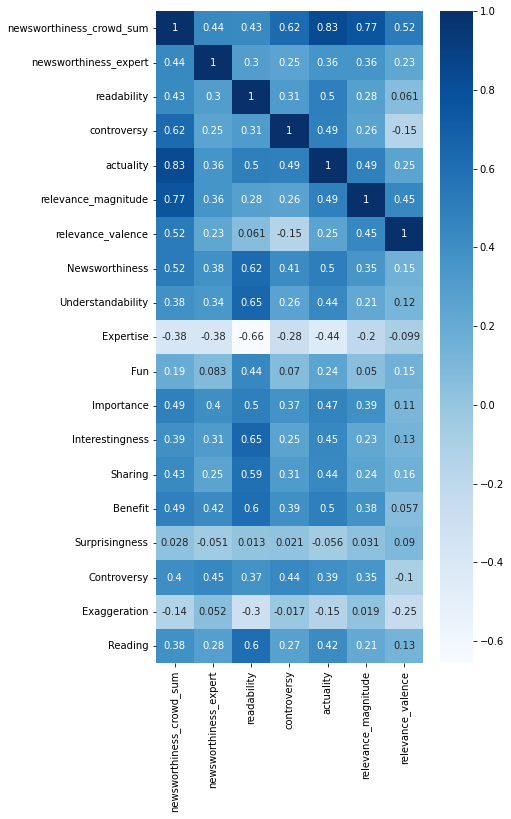

In [22]:
t_df = df[df['split']=='val']
sel_cols = ['newsworthiness_crowd_sum','newsworthiness_expert', 'readability', 'controversy', 'actuality', 'relevance_magnitude', 'relevance_valence'] + statements

heat_dict = defaultdict(list)
for col in sel_cols[:7]:
    for c in sel_cols[:]:
        #try:
        heat_dict[col].append(t_df[col].corr(t_df[c]))
        #except:
        #    continue
heat_df = pd.DataFrame(heat_dict)
heat_df.index=[col for col in sel_cols[:]]

fig, ax = plt.subplots(figsize=(6,12))     

# Define a custom color palette
cmap = 'Blues'#sns.diverging_palette(0, 110, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(heat_df, annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [2]:
mdf = 

In [6]:
mdf

,actuality,controversy,relevance_magnitude,relevance_valence,arxiv_url,id
0,4,5,3,3,http://arxiv.org/abs/2101.08325v3,id_0
1,3,4,4,4,http://arxiv.org/abs/2101.08325v3,id_1
2,5,5,5,4,http://arxiv.org/abs/2101.08325v3,id_2
3,4,3,2,3,http://arxiv.org/abs/2101.09588v2,id_3
4,4,1,5,4,http://arxiv.org/abs/2101.09588v2,id_4
...,...,...,...,...,...,...
1495,4,4,5,4,http://arxiv.org/abs/2108.01239v1,id_1495
1496,5,5,3,4,http://arxiv.org/abs/2108.01239v1,id_1496
1497,4,3,4,4,http://arxiv.org/abs/2109.04717v1,id_1497
1498,1,2,1,3,http://arxiv.org/abs/2109.04717v1,id_1498


In [9]:
keys = ['actuality', 'controversy', 'relevance_magnitude', 'relevance_valence']
for key in keys:
    ann_df = pd.read_json('../data/nishal/mturk_unaggregated.json', orient='records')
    users = ['0', '1', '2']
    ann_df['user'] = [users[i%3] for i in range(len(ann_df))]
    a_df =  ann_df.pivot(index='arxiv_url', columns='user', values=key).reset_index()
    print(key, '#',krippendorff.alpha(np.array(a_df[users]).transpose(), level_of_measurement='ordinal'))

actuality # 0.18517374290845823
controversy # 0.14494987105022494
relevance_magnitude # 0.09384172414036618
relevance_valence # 0.1467523063084999
